In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,RidgeCV
from sklearn.model_selection import KFold
from dca.cov_util import form_lag_matrix, calc_cross_cov_mats_from_data
import glob
import pdb
from statsmodels.tsa import stattools
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.append('/home/akumar/nse/neural_control')
from loaders import load_sabes, reach_segment_sabes
from decoders import lr_decoder
from utils import apply_df_filters, calc_loadings

### All pairwise regression calculations

In [4]:
# M1 dataframes

In [4]:
with open('/mnt/Secondary/data/postprocessed/sabes_cca50_cvall.dat', 'rb') as f:
    ccadf = pickle.load(f)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CCA from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
ccadf.keys()

Index(['dfile', 'bin_width', 'filter_fn', 'filter_kwargs', 'lag', 'win',
       'fold_idx', 'ccamodel', 'fl'],
      dtype='object')

In [7]:
from sklearn.cross_decomposition import CCA

In [8]:
# What is the ambient canonical correlation?
data_files = np.unique(ccadf['fl'].values)
cc_ambient = np.zeros(len(data_files))
cc_coefs = np.zeros(len(data_files), dtype=np.object)
for i, data_file in enumerate(data_files):
    df_ = apply_df_filters(ccadf, fl=data_file, fold_idx=0)
    assert(df_.shape[0] == 1)

    with open(df_.iloc[0]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)
    


    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    ccamodel = CCA(n_components=min(X.shape[-1], Y.shape[1]))
    ccamodel.fit(X, Y)
    X_c, Y_c = ccamodel.transform(X, Y)
    ccc2 = np.array([scipy.stats.pearsonr(X_c[:, j], Y_c[:, j])[0] for j in range(X_c.shape[1])])    
    cc_coefs[i] = ccc2

/tmp/ipykernel_28107/118738078.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cc_coefs = np.zeros(len(data_files), dtype=np.object)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:108: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:108: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [ ]:
X_c.shape

In [11]:
ccc50 = np.array([c[0:50] for c in cc_coefs])

In [8]:
# with open('ccc_dense.pkl', 'wb') as f:
#     f.write(pickle.dumps(cc_coefs))
with open('ccc_dense.pkl', 'rb') as f:
    cc_coefs = pickle.load(f)

In [12]:
cc_ambient = np.array([np.sum(c) for c in cc_coefs])

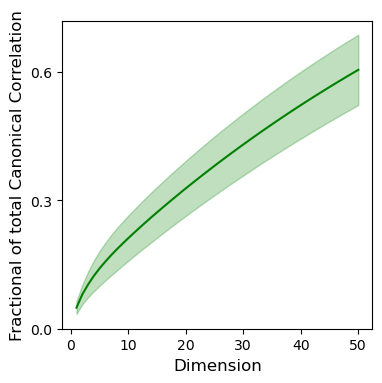

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ccc50norm = np.divide(np.cumsum(ccc50, axis=1), cc_ambient[:, np.newaxis])

x = np.arange(1, 51)
ccavg = np.mean(ccc50norm, axis=0)
ccastd = np.std(ccc50norm, axis=0)

ax.plot(x, ccavg, 'g')
ax.fill_between(x, ccavg - ccastd, ccavg + ccastd, alpha=0.25, color='g')

ax.set_ylabel('Fractional of total Canonical Correlation', fontsize=12)
ax.set_xlabel('Dimension', fontsize=12)
ax.set_yticks([0, 0.3, 0.6])
#fig.savefig('/home/akumar/nse/neural_control/figs/cca/cc_coefs.pdf', bbox_inches='tight', pad_inches=0)

In [8]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indyM1_df = pd.DataFrame(indy_df)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
locoM1_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
locoS1_df = apply_df_filters(loco_df,
                        loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'},
                        decoder_args={'trainlag':4, 'testlag':4, 'decoding_window':5})

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
with open('/mnt/Secondary/data/postprocessed/indy_S1_df.dat', 'rb') as f:
    rl2 = pickle.load(f)
indyS1_df = pd.DataFrame(rl2)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
S1df = pd.concat([locoS1_df, indyS1_df])

In [20]:
from sklearn.decomposition import PCA

In [16]:
# Plot the variance captured by CCA vs. PCA in S1/M1
data_files = np.unique(ccadf['fl'].values)
dimvals = np.arange(1, 51, 2)

varpcaM1 = np.zeros((len(data_files), 5, dimvals.size))
varccaM1 = np.zeros((len(data_files), 5, dimvals.size))

varpcaS1 = np.zeros((len(data_files), 5, dimvals.size))
varccaS1 = np.zeros((len(data_files), 5, dimvals.size))

for i, data_file in enumerate(data_files):

    fname = data_file.split('/')[-1].split('.pkl')[0]

    datM1 = load_sabes('/mnt/Secondary/data/sabes/%s.mat' % fname, region='M1')
    datS1 = load_sabes('/mnt/Secondary/data/sabes/%s.mat' % fname, region='S1')

    for fold_idx, (train_idxs, test_idxs) in tqdm(enumerate(KFold(n_splits=5).split(datM1['spike_rates'].squeeze()))):
        X = datM1['spike_rates'].squeeze()[train_idxs]
        pcamodel = PCA(n_components=50)
        pcamodel.fit(X)
        
        df_ = apply_df_filters(ccadf, fl=data_file, fold_idx=fold_idx)
        assert(df_.shape[0] == 1)

        var_ambient = np.trace(np.cov(X, rowvar=False))
        for j, d in enumerate(dimvals):
            varpcaM1[i, fold_idx, j] = np.sum(pcamodel.explained_variance_ratio_[:d])
            
            xx = X @ df_.iloc[0]['ccamodel'].y_rotations_[:, 0:d]
            if xx.shape[1] == 1:
                varccaM1[i, fold_idx, j] = np.var(xx)/var_ambient
            else:
                varccaM1[i, fold_idx, j] = np.trace(np.cov(xx, rowvar=False))/var_ambient

    for fold_idx, (train_idxs, test_idxs) in tqdm(enumerate(KFold(n_splits=5).split(datS1['spike_rates'].squeeze()))):
        X = datS1['spike_rates'].squeeze()[train_idxs]
        pcamodel = PCA(n_components=50)
        pcamodel.fit(X)
        
        df_ = apply_df_filters(ccadf, fl=data_file, fold_idx=fold_idx)
        assert(df_.shape[0] == 1)

        var_ambient = np.trace(np.cov(X, rowvar=False))
        for j, d in enumerate(dimvals):
            varpcaS1[i, fold_idx, j] = np.sum(pcamodel.explained_variance_ratio_[:d])

            xx = X @ df_.iloc[0]['ccamodel'].x_rotations_[:, 0:d]
            if xx.shape[1] == 1:
                varccaS1[i, fold_idx, j] = np.var(xx)/var_ambient
            else:
                varccaS1[i, fold_idx, j] = np.trace(np.cov(xx, rowvar=False))/var_ambient



96


5it [00:02,  2.41it/s]
5it [00:01,  4.07it/s]


96


5it [00:01,  3.02it/s]
5it [00:01,  2.91it/s]


96


5it [00:02,  2.36it/s]
5it [00:02,  2.13it/s]


96


5it [00:00,  6.20it/s]
5it [00:01,  4.87it/s]


96


5it [00:01,  2.58it/s]
5it [00:01,  2.64it/s]


96


5it [00:01,  3.02it/s]
5it [00:01,  2.97it/s]


96


5it [00:01,  4.77it/s]
5it [00:00,  5.53it/s]


96


5it [00:02,  2.19it/s]
5it [00:02,  2.35it/s]


In [33]:
varccaM1.shape

(8, 5, 25)

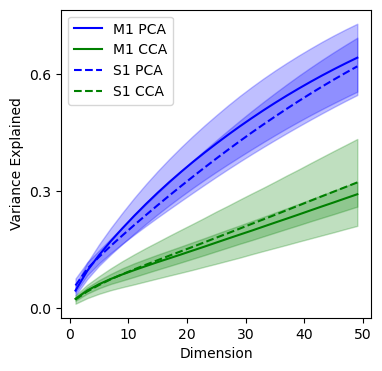

In [50]:
fig, ax = plt.subplots(figsize=(4, 4))

def plot_trace(x, color, dashed=False):
    xavg = np.mean(x, axis=1)
    if dashed:
        h = ax.plot(dimvals, np.mean(xavg, axis=0), color=color, linestyle='dashed')
    else:
        h = ax.plot(dimvals, np.mean(xavg, axis=0), color=color)

    ax.fill_between(dimvals, np.mean(xavg, axis=0) - np.std(xavg, axis=0), np.mean(xavg, axis=0) + np.std(xavg, axis=0), color=color, alpha=0.25)
    return h

h1 = plot_trace(varpcaM1, 'b')
h2 = plot_trace(varccaM1, 'g')

h3 = plot_trace(varpcaS1, 'b', dashed=True)
h4 = plot_trace(varccaS1, 'g', dashed=True)

ax.set_xlabel('Dimension')
ax.set_ylabel('Variance Explained')
ax.set_yticks([0.0, 0.3, 0.6])

ax.legend([h1[0], h2[0], h3[0], h4[0]], ['M1 PCA', 'M1 CCA', 'S1 PCA', 'S1 CCA'])

fig.savefig('/home/akumar/nse/neural_control/figs/cca/var_explained.pdf', bbox_inches='tight', pad_inches=0)

In [6]:
fls = np.unique(ccadf['fl'].values)

In [12]:
# CC to SS regression
lag = 0
w = 5
dims = np.array([2, 4, 6, 8, 12])

rl =[]

for i, fl in tqdm(enumerate(fls)):
    with open(fl, 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    y = datM1['spike_rates'].squeeze()
    x = datS1['spike_rates'].squeeze()


    # Get the subspaces
    data_file = fl.split('/')[-1].split('.pkl')[0]
    data_file += '.mat'

    for j, dim in enumerate(dims):
        if 'indy' in data_file:
            pcadfM1 = apply_df_filters(indyM1_df, data_file=data_file, dimreduc_method='PCA', dim=dim)
            pcadfS1 = apply_df_filters(indyS1_df, data_file=data_file, dimreduc_method='PCA', dim=dim)
        elif 'loco' in data_file:
            pcadfM1 = apply_df_filters(locoM1_df, data_file=data_file, dimreduc_method='PCA', dim=dim)
            pcadfS1 = apply_df_filters(locoS1_df, data_file=data_file, dimreduc_method='PCA', dim=dim)

        assert(pcadfM1.shape[0] == 5)
        assert(pcadfS1.shape[0] == 5)

        if 'indy' in data_file:
            lqgdfM1 = apply_df_filters(indyM1_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
            lqgdfS1 = apply_df_filters(indyS1_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
        elif 'loco' in data_file:
            lqgdfM1 = apply_df_filters(locoM1_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
            lqgdfS1 = apply_df_filters(locoS1_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})

        assert(lqgdfM1.shape[0] == 5)
        assert(lqgdfS1.shape[0] == 5)

        train_test_idxs = list(KFold(n_splits=5).split(x))

        for fold in range(5):
            dc_ = apply_df_filters(ccadf, fold_idx=fold, fl=fl)
            model = dc_.iloc[0]['ccamodel']

            VccaS1 = model.x_rotations_[:, 0:dim]
            VccaM1 = model.y_rotations_[:, 0:dim]

            VpcaM1 = apply_df_filters(pcadfM1, fold_idx=fold).iloc[0]['coef'][:, 0:dim]
            VpcaS1 = apply_df_filters(pcadfS1, fold_idx=fold).iloc[0]['coef'][:, 0:dim]

            VlqgM1 = apply_df_filters(lqgdfM1, fold_idx=fold).iloc[0]['coef'][:, 0:dim]
            VlqgS1 = apply_df_filters(lqgdfS1, fold_idx=fold).iloc[0]['coef'][:, 0:dim]


            coef_dict = {'S1_PCA':VpcaS1, 'S1_FCCA':VlqgS1, 'S1_CCA':VccaS1, 'M1_PCA':VpcaM1, 'M1_FCCA':VlqgM1, 'M1_CCA':VccaM1}

            # Calculate subspace angles and loadings here (in an intelligent way)
            loadings_dict = {}
            for k, v in coef_dict.items():
                loadings_dict[k] = calc_loadings(v)

            ssa_dict = {}
            for k1, v1 in coef_dict.items():
                for k2, v2 in coef_dict.items():
                    if k1 == k2:
                        continue
                    if ('M1' in k1 and 'M1' in k2) or ('S1' in k1 and 'S1' in k2):
                        try:
                            ssa_dict[frozenset((k1, k2))] = scipy.linalg.subspace_angles(v1, v2)
                        except:
                            pdb.set_trace()

            trainseries_dict = {}
            testseries_dict = {}
            for k, v in coef_dict.items():
                if 'S1' in k:
                    trainseries_dict[k] = x[train_test_idxs[fold][0]] @ v
                    testseries_dict[k] = x[train_test_idxs[fold][1]] @ v
                else:
                    trainseries_dict[k] = y[train_test_idxs[fold][0]] @ v
                    testseries_dict[k] = y[train_test_idxs[fold][1]] @ v

            r2_dict = {}
            sscoef_dict = {}
            ncoef_dict = {}

            # All pairwise regressions
            for k1, v1 in trainseries_dict.items():
                for k2, v2 in trainseries_dict.items():
                    if k1 == k2:
                        continue
                    else:
                        xx_train = form_lag_matrix(v1, w)
                        xx_test = form_lag_matrix(testseries_dict[k1], w)

                        yy_train = v2[w//2:]
                        yy_train = yy_train[:xx_train.shape[0]]

                        yy_test = testseries_dict[k2][w//2:]
                        yy_test = yy_test[:xx_test.shape[0]]
 
                        # Standardize

                        xx_train = StandardScaler().fit_transform(xx_train)
                        xx_test = StandardScaler().fit_transform(xx_test)

                        yy_train = StandardScaler().fit_transform(yy_train)
                        yy_test = StandardScaler().fit_transform(yy_test)

                        linmodel = RidgeCV()
                        linmodel.fit(xx_train, yy_train)
                        r2_dict[(k1, k2)] = linmodel.score(xx_test, yy_test)
                        
                        # At this stage, calculate the norm contribution of each subspace to the regression (this requires unwinding the windowing)
                        # and the norm contribution of each neuron in the ambient space (cascaded loading essentially)
                        
                        sscoef_dict[(k1, k2)] = np.sqrt(np.sum(np.sum(np.power(linmodel.coef_.reshape((dim, dim, w), order='F'), 2), axis=-1), axis=0))
                        cascaded_coef = np.einsum('ij,hjk->hik', coef_dict[k1], linmodel.coef_.reshape((dim, dim, w), order='F'))
                        ncoef_dict[(k1, k2)] = np.sqrt(np.sum(np.sum(np.power(cascaded_coef, 2), axis=-1), axis=0))

            result_dict = {}
            result_dict['fl'] = fl
            result_dict['dim'] = dim
            result_dict['fold'] = fold
            result_dict['sscoef_dict'] = sscoef_dict
            result_dict['ncoef_dict'] = ncoef_dict
            result_dict['r2_dict'] = r2_dict
            result_dict['loadings_dict'] = loadings_dict
            result_dict['ssa_dict'] = ssa_dict
            rl.append(result_dict)

8it [03:17, 24.64s/it]


In [13]:
rdf = pd.DataFrame(rl)

In [16]:
# Arrange array to be fed into pcolor
subspaces = ['S1_PCA', 'S1_FCCA', 'S1_CCA', 'M1_CCA', 'M1_FCCA', 'M1_PCA']
r2_array = np.zeros((len(subspaces), len(subspaces)))

# Manually arrange this
rdf_ = apply_df_filters(rdf, dim=4)

for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            continue
        else:
            r2_array[i, j] = np.mean([rdf_.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_.shape[0])])

In [18]:
r2_array[1, :]

array([0.39166891, 0.        , 0.66892247, 0.15394879, 0.18593174,
       0.09502277])

In [17]:
r2_array[0, :]

array([0.        , 0.4802995 , 0.3944533 , 0.11484072, 0.15287153,
       0.08147147])

In [19]:
ss_array = np.zeros((len(subspaces), len(subspaces)))
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            continue
        else:
            if frozenset((s1, s2)) in rdf_.iloc[0]['ssa_dict'].keys():
                ss_array[i, j] = np.mean([rdf_.iloc[k]['ssa_dict'][frozenset((s1, s2))] for k in range(rdf_.shape[0])])

In [20]:
lc_array = np.zeros((len(subspaces), len(subspaces)))
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            continue
        else:
            if ('M1' in s1 and 'M1' in s2) or ('S1' in s1 and 'S1' in s2):
                lc_array[i, j] = np.mean([scipy.stats.spearmanr(rdf_.iloc[k]['loadings_dict'][s1], rdf_.iloc[k]['loadings_dict'][s2])[0] for k in range(rdf_.shape[0])])

In [21]:
with open('s12m1regression.pkl', 'wb') as f:
    f.write(pickle.dumps(rdf))
    f.write(pickle.dumps(r2_array))
    f.write(pickle.dumps(ss_array))
    f.write(pickle.dumps(lc_array))

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

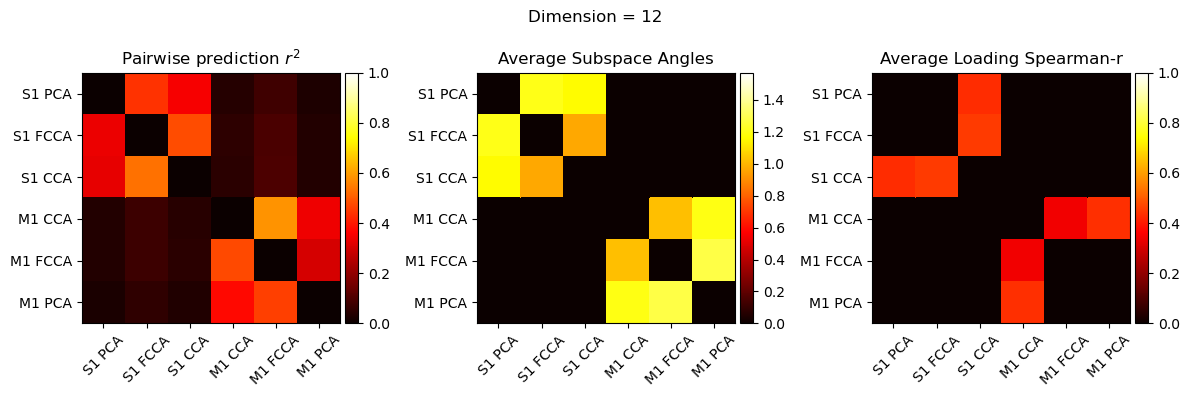

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

im1 = ax[0].pcolor(r2_array, vmin=0, vmax=1, cmap='hot')
ax.invert_yaxis()
ax[0].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[0].set_xticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'], rotation=45)
ax[0].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[0].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
ax[0].set_title('Pairwise prediction ' + r'$r^2$')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolor(ss_array, vmin=0, vmax=np.pi/2, cmap='hot')
ax[1].invert_yaxis()
ax[1].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[1].set_xticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'], rotation=45)
ax[1].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[1].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
ax[1].set_title('Average Subspace Angles')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

im3 = ax[2].pcolor(lc_array, vmin=0, vmax=1, cmap='hot')
ax[2].invert_yaxis()
ax[2].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[2].set_xticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'], rotation=45)
ax[2].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[2].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
ax[2].set_title('Average Loading Spearman-r')

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

fig.suptitle('Dimension = 12')
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/pairwise_r2ssd12.pdf', bbox_inches='tight', pad_inches=0)

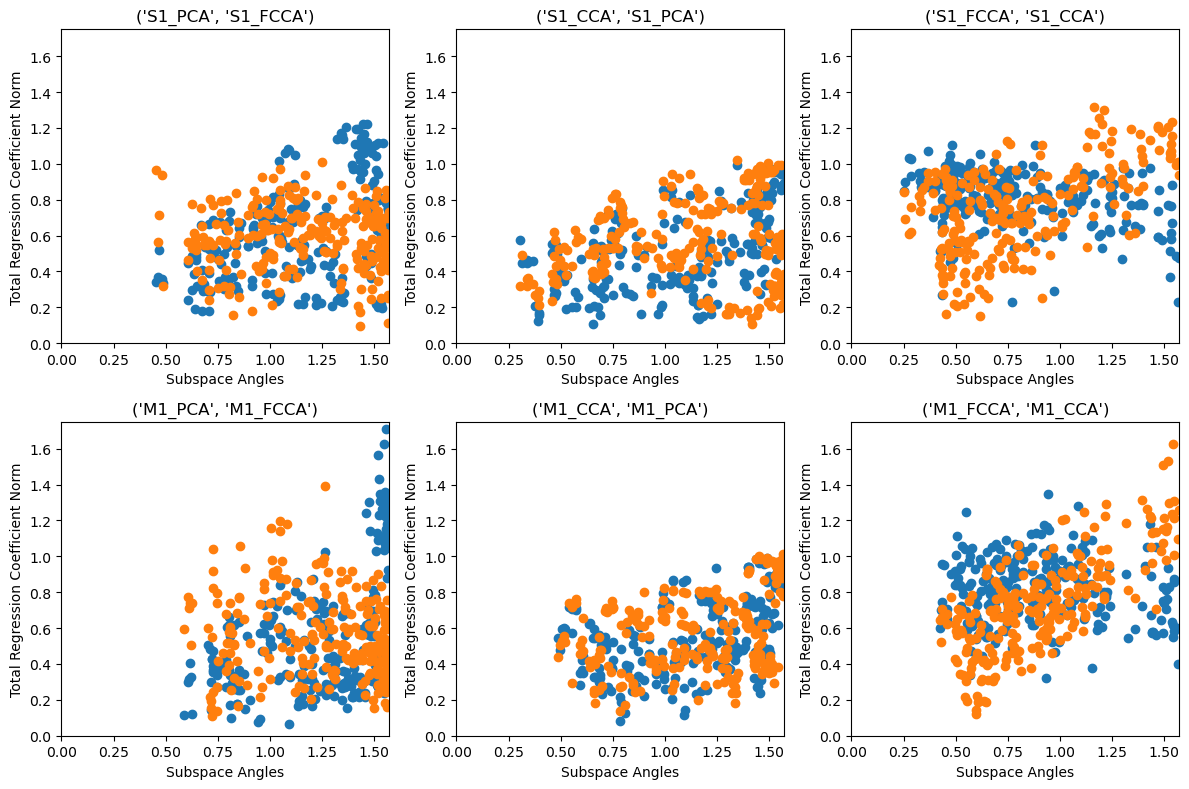

In [61]:
# Show that there is no strong relationship between subspace angle and regression coefficient
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

rdf_ = apply_df_filters(rdf, dim=6)
pairs = [('S1_PCA', 'S1_FCCA'), ('S1_CCA', 'S1_PCA'), ('S1_FCCA', 'S1_CCA'), ('M1_PCA', 'M1_FCCA'), ('M1_CCA', 'M1_PCA'), ('M1_FCCA', 'M1_CCA')]

for i in range(len(pairs)):
    a = ax[np.unravel_index(i, (2, 3))]
    x = []
    y1 = []
    y2 = []
    for j in range(rdf_.shape[0]):
        x.extend(rdf_.iloc[j]['ssa_dict'][frozenset(pairs[i])])
        y1.extend(rdf_.iloc[j]['sscoef_dict'][pairs[i]])
        y2.extend(rdf_.iloc[j]['sscoef_dict'][tuple(list(pairs[i])[::-1])])
    a.scatter(x, y1)
    a.scatter(x, y2)
    a.set_title(pairs[i])
    a.set_ylabel('Total Regression Coefficient Norm')
    a.set_xlabel('Subspace Angles')
    a.set_ylim([0, 1.75])
    a.set_xlim([0, np.pi/2])
    fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/ssa_coef_scatter.pdf', bbox_inches='tight', pad_inches=0)

In [62]:
rdf_.iloc[0]['ncoef_dict'][('S1_PCA', 'S1_FCCA')].shape

(86,)

In [74]:
import itertools

In [95]:
def quartile_divide(x1, x2, x1q, x2q):
    comb_idxs = []
    def isin(x, range_):
        if x >= range_[0] and x <= range_[1]:
            return True
        else:
            return False

    for quartile_comb in itertools.product(x1q, x2q):
        comb_idxs.append([idx for idx in range(len(x1)) if isin(x1[idx], quartile_comb[0]) and isin(x2[idx], quartile_comb[1]) ])

    assert(sum([len(c) for c in comb_idxs]) >= len(x1))

    return comb_idxs

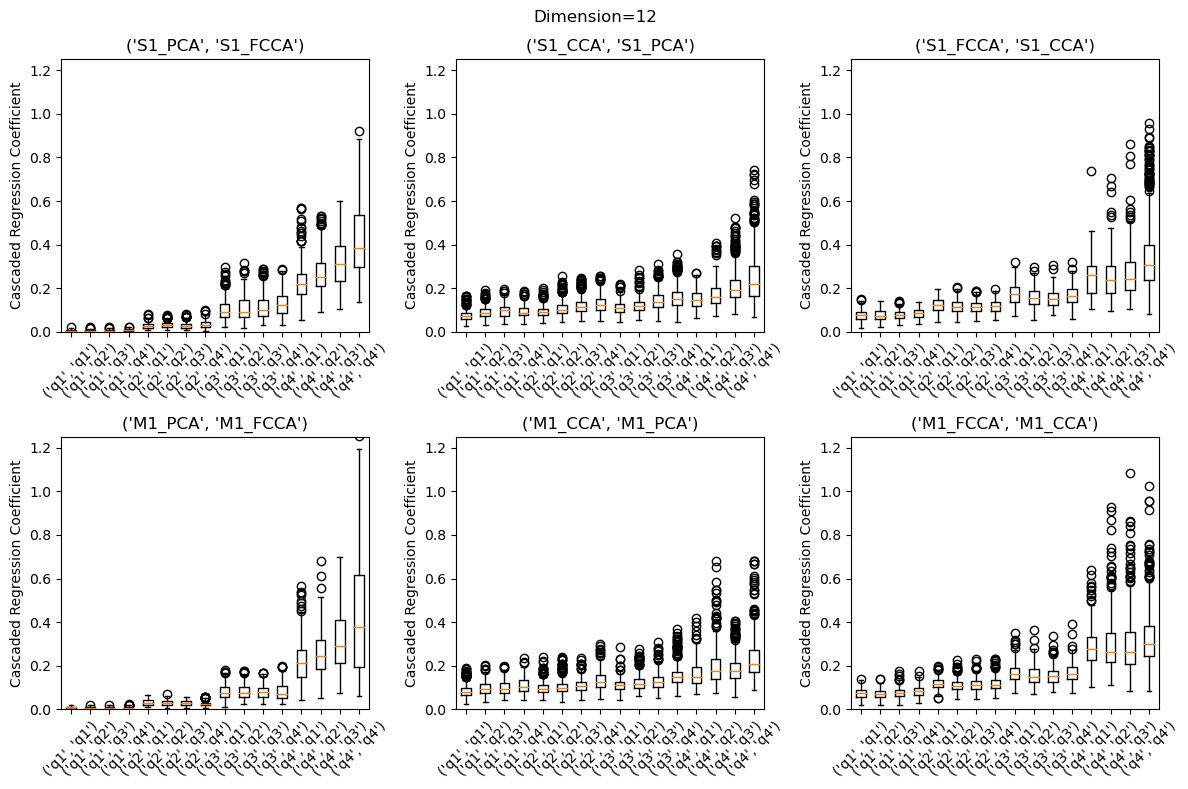

In [112]:
# Show that there is no strong relationship between subspace angle and regression coefficient
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
dim = 12
rdf_ = apply_df_filters(rdf, dim=dim)
pairs = [('S1_PCA', 'S1_FCCA'), ('S1_CCA', 'S1_PCA'), ('S1_FCCA', 'S1_CCA'), ('M1_PCA', 'M1_FCCA'), ('M1_CCA', 'M1_PCA'), ('M1_FCCA', 'M1_CCA')]

for i in range(len(pairs)):
    a = ax[np.unravel_index(i, (2, 3))]
    x1 = []
    x2 = []
    y1 = []
    y2 = []

    for j in range(rdf_.shape[0]):
        x1.extend(rdf_.iloc[j]['loadings_dict'][pairs[i][0]])
        x2.extend(rdf_.iloc[j]['loadings_dict'][pairs[i][1]])               
        y1.extend(rdf_.iloc[j]['ncoef_dict'][pairs[i]])
        y2.extend(rdf_.iloc[j]['ncoef_dict'][tuple(list(pairs[i])[::-1])])

    x1 = np.array(x1)
    x2 = np.array(x2)
    y1 = np.array(y1)
    y2 = np.array(y2)

    # Divide x1, x2 into all pairwise quartiles
    x1q = np.quantile(x1, [0., 0.25, 0.5, 0.75, 1.])
    x1q = [(x1q[k], x1q[k + 1]) for k in range(4)]
    x2q = np.quantile(x2, [0, 0.25, 0.5, 0.75, 1.])
    x2q = [(x2q[k], x2q[k + 1]) for k in range(4)]

    comb_idxs = quartile_divide(x1, x2, x1q, x2q)
    quartile_strings = list(itertools.product(['q1', 'q2', 'q3', 'q4'], ['q1', 'q2', 'q3', 'q4']))
    coefs_by_quartile1 = [np.array(y1)[c] for c in comb_idxs]
    coefs_by_quartile2 = [np.array(y2)[c] for c in comb_idxs] 

    a.boxplot(coefs_by_quartile1)
    a.set_xticklabels(quartile_strings, rotation=45)
    a.set_title(pairs[i])
    a.set_ylabel('Cascaded Regression Coefficient')
    #a.set_xlabel('Subspace Angles')
    a.set_ylim([0, 1.25])
    #a.set_xlim([0, np.pi/2])
fig.suptitle('Dimension=%d' % dim)
fig.tight_layout()

fig.savefig('/home/akumar/nse/neural_control/figs/cca/ncoef_boxd12.pdf', bbox_inches='tight', pad_inches=0)

### Comparison of Behavioral Decoding Regressor

(1) Quartile comparison plots of FCCA/CCA behavioral decoding
(2) At fixed dimensions, plot of the r^2 vs. lag for the different regions/subspaces

In [4]:
# restart kernel and re-load the relevant dataframes (memory may be a challenge)
with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    result_list = pickle.load(f)
with open('/mnt/Secondary/data/postprocessed/indy_S1_df.dat', 'rb') as f:
    rl2 = pickle.load(f)

loco_df = pd.DataFrame(result_list)
indy_df = pd.DataFrame(rl2)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_acausal.dat', 'rb') as f:
    rl = pickle.load(f)
loco_df_acausal = pd.DataFrame(rl)

In [6]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_laggap.dat', 'rb') as f:
    rl = pickle.load(f)
loco_df_laggap = pd.DataFrame(rl)

In [7]:
# Narrow down by the desired loader args
loco_df = apply_df_filters(loco_df, loader_args=[{'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'}, 
                           {'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'}])

In [8]:
with open('/home/akumar/nse/neural_control/analysis_scripts/cca_behavioral_decoding.dat', 'rb') as f:
    cca_r2 = pickle.load(f)
    _ = pickle.load(f)
    ncoef_cca = pickle.load(f)

In [9]:
with open('/mnt/Secondary/data/postprocessed/sabes_cca50_cvall.dat', 'rb') as f:
    ccadf = pickle.load(f)

fls = list(np.unique(ccadf['fl'].values))
fls = [f.split('pkl')[0].split('/')[-1] + 'mat' for f in fls]
cca_dims = list(np.arange(1, 31, 2))

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CCA from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
# CCA ordering
# lags = [-6, -4, -2, -1, 0, 1, 2, 4, 6]

decoders = [{'trainlag': 6, 'testlag': 6, 'decoding_window':5},
            {'trainlag': 4, 'testlag': 4, 'decoding_window':5},
            {'trainlag': 2, 'testlag': 2, 'decoding_window':5},
            {'trainlag': 1, 'testlag': 1, 'decoding_window':5},
            {'trainlag': 0, 'testlag': 0, 'decoding_window':5},
            {'trainlag': -1, 'testlag': -1, 'decoding_window':5},
            {'trainlag': -2, 'testlag': -2, 'decoding_window':5},
            {'trainlag': -4, 'testlag': -4, 'decoding_window':5},
            {'trainlag': -6, 'testlag': -6, 'decoding_window':5}]

# Assemble r2 arrays for pca, fcca, cca across dimensions, lags, and regiosn
data_files = [f for f in fls if 'loco' in f]

dims = np.array([1, 5, 9, 13, 17, 21, 27])
cca_dims = list(np.arange(1, 31, 2))

r2fc_M1 = np.zeros((len(data_files), len(decoders), dims.size, 5))
r2fc_S1 = np.zeros((len(data_files), len(decoders), dims.size, 5))

r2pc_M1 = np.zeros((len(data_files), len(decoders), dims.size, 5))
r2pc_S1 = np.zeros((len(data_files), len(decoders), dims.size, 5))

r2cc_M1 = np.zeros((len(data_files), len(decoders), dims.size, 5))
r2cc_S1 = np.zeros((len(data_files), len(decoders), dims.size, 5))


# S1
for i, data_file in tqdm(enumerate(data_files)):
    for idx, decoder in enumerate(decoders):
        if decoder['trainlag'] in [0, 2, 4, 6]:
            ldf = apply_df_filters(loco_df, data_file=data_file, decoder_args=decoder, dimreduc_method='LQGCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'})
            pdf = apply_df_filters(loco_df, data_file=data_file, decoder_args=decoder, dimreduc_method='PCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'})
        elif decoder['trainlag'] in [-2, -4, -6]:
            ldf = apply_df_filters(loco_df_acausal, data_file=data_file, decoder_args=decoder, dimreduc_method='LQGCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'})
            pdf = apply_df_filters(loco_df_acausal, data_file=data_file, decoder_args=decoder, dimreduc_method='PCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'})
        elif decoder['trainlag'] in [-1, 1]:
            ldf = apply_df_filters(loco_df_laggap, data_file=data_file, decoder_args=decoder, dimreduc_method='LQGCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'})
            pdf = apply_df_filters(loco_df_laggap, data_file=data_file, decoder_args=decoder, dimreduc_method='PCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'})
        for j, dim in enumerate(dims):               
            for f in range(5):
                ldf_ = apply_df_filters(ldf, dim=dim, fold_idx=f)
                pdf_ = apply_df_filters(pdf, dim=dim, fold_idx=f)
                try:
                    assert(ldf_.shape[0] == 1)
                    assert(pdf_.shape[0] == 1)
                except:
                    pdb.set_trace()

                r2fc_S1[i, idx, j, f] = ldf_.iloc[0]['r2'][1]            
                r2pc_S1[i, idx, j, f] = pdf_.iloc[0]['r2'][1]            
                # CCA lags go in reverse order
                r2cc_S1[i, idx, j, f] = cca_r2[fls.index(data_file), f, len(decoders)-(idx + 1), cca_dims.index(dim), 0, 1]

# M1
for i, data_file in tqdm(enumerate(data_files)):
    for idx, decoder in enumerate(decoders):
        if decoder['trainlag'] in [0, 2, 4, 6]:
            ldf = apply_df_filters(loco_df, data_file=data_file, decoder_args=decoder, dimreduc_method='LQGCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'})
            pdf = apply_df_filters(loco_df, data_file=data_file, decoder_args=decoder, dimreduc_method='PCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'})
        elif decoder['trainlag'] in [-2, -4, -6]:
            ldf = apply_df_filters(loco_df_acausal, data_file=data_file, decoder_args=decoder, dimreduc_method='LQGCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'})
            pdf = apply_df_filters(loco_df_acausal, data_file=data_file, decoder_args=decoder, dimreduc_method='PCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'})
        elif decoder['trainlag'] in [-1, 1]:
            ldf = apply_df_filters(loco_df_laggap, data_file=data_file, decoder_args=decoder, dimreduc_method='LQGCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'})
            pdf = apply_df_filters(loco_df_laggap, data_file=data_file, decoder_args=decoder, dimreduc_method='PCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'})
        for j, dim in enumerate(dims):               
            for f in range(5):
                ldf_ = apply_df_filters(ldf, dim=dim, fold_idx=f)
                pdf_ = apply_df_filters(pdf, dim=dim, fold_idx=f)
                try:
                    assert(ldf_.shape[0] == 1)
                    assert(pdf_.shape[0] == 1)
                except:
                    pdb.set_trace()

                r2fc_M1[i, idx, j, f] = ldf_.iloc[0]['r2'][1]            
                r2pc_M1[i, idx, j, f] = pdf_.iloc[0]['r2'][1]            
                # CCA lags go in reverse order
                r2cc_M1[i, idx, j, f] = cca_r2[fls.index(data_file), f, len(decoders)-(idx + 1), cca_dims.index(dim), 1, 1]


7it [00:02,  3.45it/s]
7it [00:02,  3.43it/s]


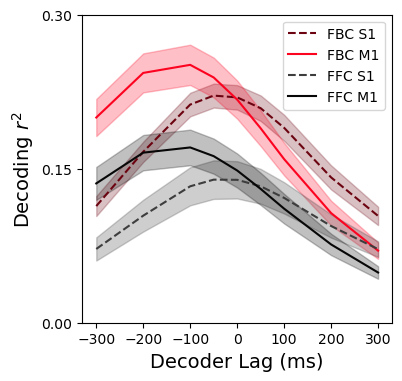

In [11]:
# Plot the decoding accuracy across dimensions 
# We could include the indy session here as well
fig, ax = plt.subplots(figsize=(4, 4))
lags = [d['trainlag'] for d in decoders]

# Dim idx
i = -1

# FCCA
# Averaged over folds
x = np.mean(r2fc_S1[..., i, :], axis=-1)
xmu = np.mean(x, axis=0)
xstd = np.std(x, axis=0)
ax.fill_between(-1*50 * np.array(lags), xmu - 1/np.sqrt(7) * xstd, xmu + 1/np.sqrt(7) * xstd, alpha=0.25, color='#6b0410')
ax.plot(-1*50 * np.array(lags), xmu, color='#6b0410', linestyle='--')
x = np.mean(r2fc_M1[..., i, :], axis=-1)
xmu = np.mean(x, axis=0)
xstd = np.std(x, axis=0)
ax.fill_between(-1*50 * np.array(lags), xmu - 1/np.sqrt(7) * xstd, xmu + 1/np.sqrt(7) * xstd, alpha=0.25, color='#fc0320')
ax.plot(-1*50 * np.array(lags), xmu, color='#fc0320', linestyle='-')


# PCA
# Averaged over folds
x = np.mean(r2pc_S1[..., i, :], axis=-1)
xmu = np.mean(x, axis=0)
xstd = np.std(x, axis=0)
ax.fill_between(-1*50 * np.array(lags), xmu - 1/np.sqrt(7) * xstd, xmu + 1/np.sqrt(7) * xstd, alpha=0.25, color='#3d3d3d')
ax.plot(-1*50 * np.array(lags), xmu, color='#3d3d3d', linestyle='--')

x = np.mean(r2pc_M1[..., i, :], axis=-1)
xmu = np.mean(x, axis=0)
xstd = np.std(x, axis=0)
ax.fill_between(-1*50 * np.array(lags), xmu - 1/np.sqrt(7) * xstd, xmu + 1/np.sqrt(7) * xstd, alpha=0.25, color='#080707')
ax.plot(-1*50 * np.array(lags), xmu, color='#080707', linestyle='-')


# CCA
# Averaged over folds
x = np.mean(r2cc_S1[..., i, :], axis=-1)
xmu = np.mean(x, axis=0)
xstd = np.std(x, axis=0)
# ax.fill_between(-1*50 * np.array(lags), xmu - 1/np.sqrt(7) * xstd, xmu + 1/np.sqrt(7) * xstd, alpha=0.25, color='#3d7025')
# ax.plot(-1*50 * np.array(lags), xmu, color='#3d7025', linestyle='--')

x = np.mean(r2cc_M1[..., i, :], axis=-1)
xmu = np.mean(x, axis=0)
xstd = np.std(x, axis=0)
# ax.fill_between(-1*50 * np.array(lags), xmu - 1/np.sqrt(7) * xstd, xmu + 1/np.sqrt(7) * xstd, alpha=0.25, color='#59bf28')
# ax.plot(-1*50 * np.array(lags), xmu, color='#59bf28', linestyle='-')

ax.set_xlabel('Decoder Lag (ms)', fontsize=14)
ax.set_ylabel('Decoding ' + r'$r^2$', fontsize=14)
ax.set_yticks([0, 0.15, 0.3])
ax.legend(['FBC S1', 'FBC M1', 'FFC S1', 'FFC M1'], ncol=1, bbox_to_anchor=(1, 1))

# for i in range(len(dims)):
#     ax[0, i].plot(np.mean(np.mean(r2fc_S1[:, :, i, :], axis=0), axis=-1))
#     ax[0, i].plot(np.mean(np.mean(r2pc_S1[:, :, i, :], axis=0), axis=-1))
#     ax[0, i].plot(np.mean(np.mean(r2cc_S1[:, :, i, :], axis=0), axis=-1))

#     ax[1, i].plot(np.mean(np.mean(r2fc_M1[:, :, i, :], axis=0), axis=-1))
#     ax[1, i].plot(np.mean(np.mean(r2pc_M1[:, :, i, :], axis=0), axis=-1))
#     ax[1, i].plot(np.mean(np.mean(r2cc_M1[:, :, i, :], axis=0), axis=-1))

fig.savefig('/home/akumar/nse/neural_control/figs/cca/decodingvlag.pdf', bbox_inches='tight', pad_inches=0)

In [80]:
ldf_.iloc[0]['dim']

27

In [79]:
ldf_.iloc[0]['decoder_obj'].coef_.shape

(6, 135)

In [90]:
# Correlation of cascaded loadings between FCCA and CCA
fcloadings_M1 = np.zeros((len(data_files), dims.size), dtype=object)
fcloadings_S1 = np.zeros((len(data_files), dims.size), dtype=object)

pcloadings_M1 = np.zeros((len(data_files), dims.size), dtype=object)
pcloadings_S1 = np.zeros((len(data_files), dims.size), dtype=object)

ccloadings_M1 = np.zeros((len(data_files), dims.size), dtype=object)
ccloadings_S1 = np.zeros((len(data_files), dims.size), dtype=object)

decoder_M1 = decoders[2]
decoder_S1 = decoders[3]
# decoding window
w = 5

# S1
for i, data_file in tqdm(enumerate(data_files)):
    # Use lag 1 for S1
    ldf = apply_df_filters(loco_df_laggap, data_file=data_file, decoder_args=decoder_S1, dimreduc_method='LQGCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'})
    pdf = apply_df_filters(loco_df_laggap, data_file=data_file, decoder_args=decoder_S1, dimreduc_method='PCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'})
    for j, dim in enumerate(dims):               
        
        fcl = []
        pcl = []
        ccl = []

        for f in range(5):

            ldf_ = apply_df_filters(ldf, dim=dim, fold_idx=f)
            pdf_ = apply_df_filters(pdf, dim=dim, fold_idx=f)
            try:
                assert(ldf_.shape[0] == 1)
                assert(pdf_.shape[0] == 1)
            except:
                pdb.set_trace()

            cascaded_coef = np.einsum('ij,hjk->hik', ldf_.iloc[0]['coef'], ldf_.iloc[0]['decoder_obj'].coef_.reshape((6, dim, w), order='F')[2:4, ...])

            fcl.append(np.sqrt(np.sum(np.sum(np.power(cascaded_coef, 2), axis=-1), axis=0)))

            cascaded_coef = np.einsum('ij,hjk->hik', pdf_.iloc[0]['coef'], pdf_.iloc[0]['decoder_obj'].coef_.reshape((6, dim, w), order='F')[2:4, ...])
            pcl.append(np.sqrt(np.sum(np.sum(np.power(cascaded_coef, 2), axis=-1), axis=0)))

            # CCA lags go in reverse order
            ccl.append(ncoef_cca[fls.index(data_file), f, len(decoders) - (3 + 1), cca_dims.index(dim), 0])
            
        fcloadings_S1[i, j] = np.mean(fcl, axis=0)
        pcloadings_S1[i, j] = np.mean(pcl, axis=0)
        ccloadings_S1[i, j] = np.mean(ccl, axis=0)

for i, data_file in tqdm(enumerate(data_files)):
    ldf = apply_df_filters(loco_df, data_file=data_file, decoder_args=decoder_M1, dimreduc_method='LQGCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'})
    pdf = apply_df_filters(loco_df, data_file=data_file, decoder_args=decoder_M1, dimreduc_method='PCA', loader_args={'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'})
    for j, dim in enumerate(dims):               
        
        fcl = []
        pcl = []
        ccl = []

        for f in range(5):

            ldf_ = apply_df_filters(ldf, dim=dim, fold_idx=f)
            pdf_ = apply_df_filters(pdf, dim=dim, fold_idx=f)
            try:
                assert(ldf_.shape[0] == 1)
                assert(pdf_.shape[0] == 1)
            except:
                pdb.set_trace()

            cascaded_coef = np.einsum('ij,hjk->hik', ldf_.iloc[0]['coef'], ldf_.iloc[0]['decoder_obj'].coef_.reshape((6, dim, w), order='F')[2:4, ...])

            fcl.append(np.sqrt(np.sum(np.sum(np.power(cascaded_coef, 2), axis=-1), axis=0)))

            cascaded_coef = np.einsum('ij,hjk->hik', pdf_.iloc[0]['coef'], pdf_.iloc[0]['decoder_obj'].coef_.reshape((6, dim, w), order='F')[2:4, ...])
            pcl.append(np.sqrt(np.sum(np.sum(np.power(cascaded_coef, 2), axis=-1), axis=0)))

            # CCA lags go in reverse order
            ccl.append(ncoef_cca[fls.index(data_file), f, len(decoders) - (3 + 1), cca_dims.index(dim), 1])
            
        fcloadings_M1[i, j] = np.mean(fcl, axis=0)
        pcloadings_M1[i, j] = np.mean(pcl, axis=0)
        ccloadings_M1[i, j] = np.mean(ccl, axis=0)

7it [00:00, 25.58it/s]
7it [00:00, 24.07it/s]


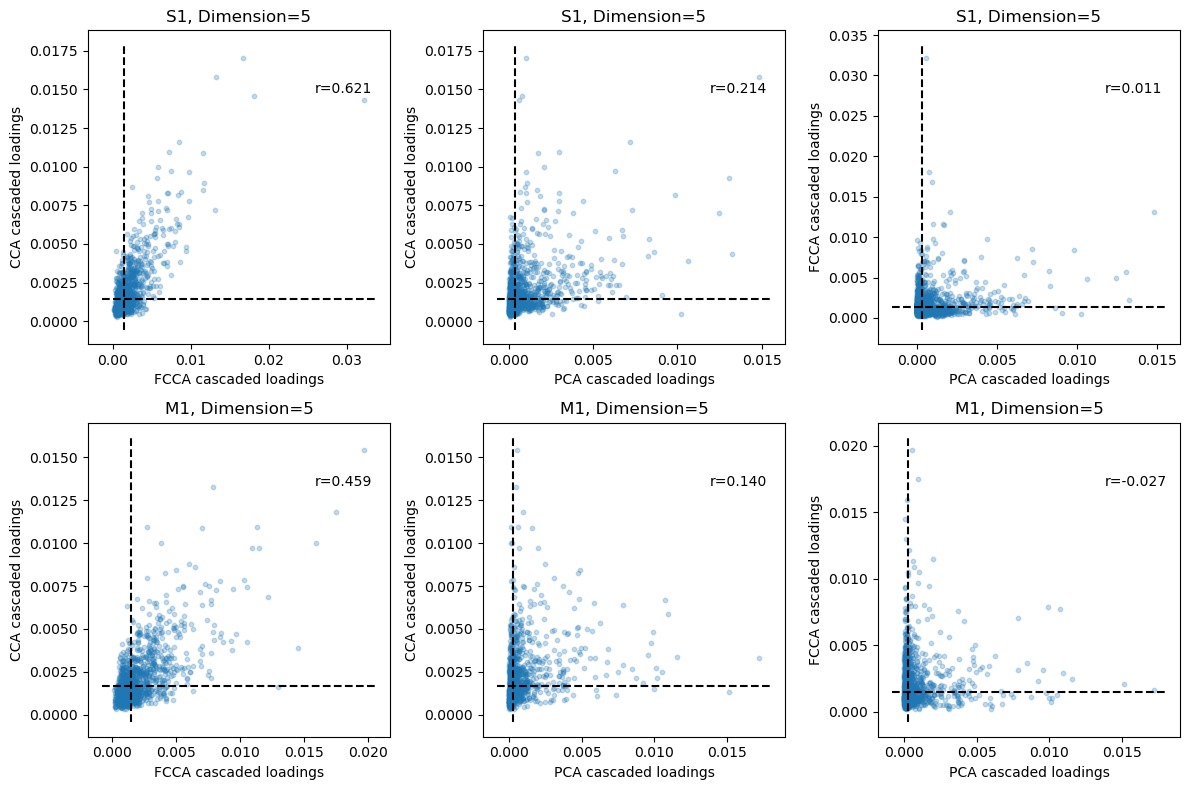

In [117]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
dim_idx = 1

# S1

x = []
for i in range(fcloadings_S1.shape[0]):
    x.extend(fcloadings_S1[i, dim_idx])

y = []
for i in range(ccloadings_S1.shape[0]):
    y.extend(ccloadings_S1[i, dim_idx])

ax[0, 0].scatter(x, y, alpha=0.25, s=10)
ax[0, 0].set_xlabel('FCCA cascaded loadings')
ax[0, 0].set_ylabel('CCA cascaded loadings')
ax[0, 0].set_title('S1, Dimension=%d' % dims[dim_idx])


# Measure the upper half specifically
xup_idxs = np.argwhere(np.array(x) > np.quantile(x, 0.5)).squeeze()
yup_idxs = np.argwhere(np.array(y) > np.quantile(y, 0.5)).squeeze()
intersct = list(set(list(xup_idxs)).intersection(set(list(yup_idxs))))
r = scipy.stats.spearmanr(np.array(x)[intersct], np.array(y)[intersct])[0]
ax[0, 0].text(0.75, 0.8, 'r=%.3f' % r, transform=ax[0, 0].transAxes)
ax[0, 0].hlines(np.quantile(y, 0.5), ax[0, 0].get_xlim()[0], ax[0, 0].get_xlim()[1], color='k', linestyles='dashed')
ax[0, 0].vlines(np.quantile(x, 0.5), ax[0, 0].get_ylim()[0], ax[0, 0].get_ylim()[1], color='k', linestyles='dashed')


x = []
for i in range(pcloadings_S1.shape[0]):
    x.extend(pcloadings_S1[i, dim_idx])

y = []
for i in range(ccloadings_S1.shape[0]):
    y.extend(ccloadings_S1[i, dim_idx])

ax[0, 1].scatter(x, y, alpha=0.25, s=10)
ax[0, 1].set_xlabel('PCA cascaded loadings')
ax[0, 1].set_ylabel('CCA cascaded loadings')
ax[0, 1].set_title('S1, Dimension=%d' % dims[dim_idx])


# Measure the upper half specifically
xup_idxs = np.argwhere(np.array(x) > np.quantile(x, 0.5)).squeeze()
yup_idxs = np.argwhere(np.array(y) > np.quantile(y, 0.5)).squeeze()
intersct = list(set(list(xup_idxs)).intersection(set(list(yup_idxs))))
r = scipy.stats.spearmanr(np.array(x)[intersct], np.array(y)[intersct])[0]
ax[0, 1].text(0.75, 0.8, 'r=%.3f' % r, transform=ax[0, 1].transAxes)
ax[0, 1].hlines(np.quantile(y, 0.5), ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyles='dashed')
ax[0, 1].vlines(np.quantile(x, 0.5), ax[0, 1].get_ylim()[0], ax[0, 1].get_ylim()[1], color='k', linestyles='dashed')


x = []
for i in range(pcloadings_S1.shape[0]):
    x.extend(pcloadings_S1[i, dim_idx])

y = []
for i in range(fcloadings_S1.shape[0]):
    y.extend(fcloadings_S1[i, dim_idx])

ax[0, 2].scatter(x, y, alpha=0.25, s=10)
ax[0, 2].set_xlabel('PCA cascaded loadings')
ax[0, 2].set_ylabel('FCCA cascaded loadings')
ax[0, 2].set_title('S1, Dimension=%d' % dims[dim_idx])

# Measure the upper half specifically
xup_idxs = np.argwhere(np.array(x) > np.quantile(x, 0.5)).squeeze()
yup_idxs = np.argwhere(np.array(y) > np.quantile(y, 0.5)).squeeze()
intersct = list(set(list(xup_idxs)).intersection(set(list(yup_idxs))))
r = scipy.stats.spearmanr(np.array(x)[intersct], np.array(y)[intersct])[0]
ax[0, 2].text(0.75, 0.8, 'r=%.3f' % r, transform=ax[0, 2].transAxes)
ax[0, 2].hlines(np.quantile(y, 0.5), ax[0, 1].get_xlim()[0], ax[0, 2].get_xlim()[1], color='k', linestyles='dashed')
ax[0, 2].vlines(np.quantile(x, 0.5), ax[0, 1].get_ylim()[0], ax[0, 2].get_ylim()[1], color='k', linestyles='dashed')



# M1
x = []
for i in range(fcloadings_M1.shape[0]):
    x.extend(fcloadings_M1[i, dim_idx])

y = []
for i in range(ccloadings_M1.shape[0]):
    y.extend(ccloadings_M1[i, dim_idx])

ax[1, 0].scatter(x, y, alpha=0.25, s=10)
ax[1, 0].set_xlabel('FCCA cascaded loadings')
ax[1, 0].set_ylabel('CCA cascaded loadings')
ax[1, 0].set_title('M1, Dimension=%d' % dims[dim_idx])

# Measure the upper half specifically
xup_idxs = np.argwhere(np.array(x) > np.quantile(x, 0.5)).squeeze()
yup_idxs = np.argwhere(np.array(y) > np.quantile(y, 0.5)).squeeze()
intersct = list(set(list(xup_idxs)).intersection(set(list(yup_idxs))))
r = scipy.stats.spearmanr(np.array(x)[intersct], np.array(y)[intersct])[0]
ax[1, 0].text(0.75, 0.8, 'r=%.3f' % r, transform=ax[1, 0].transAxes)
ax[1, 0].hlines(np.quantile(y, 0.5), ax[1, 0].get_xlim()[0], ax[1, 0].get_xlim()[1], color='k', linestyles='dashed')
ax[1, 0].vlines(np.quantile(x, 0.5), ax[1, 0].get_ylim()[0], ax[1, 0].get_ylim()[1], color='k', linestyles='dashed')

x = []
for i in range(pcloadings_M1.shape[0]):
    x.extend(pcloadings_M1[i, dim_idx])

y = []
for i in range(ccloadings_M1.shape[0]):
    y.extend(ccloadings_M1[i, dim_idx])

ax[1, 1].scatter(x, y, alpha=0.25, s=10)
ax[1, 1].set_xlabel('PCA cascaded loadings')
ax[1, 1].set_ylabel('CCA cascaded loadings')
ax[1, 1].set_title('M1, Dimension=%d' % dims[dim_idx])

# Measure the upper half specifically
xup_idxs = np.argwhere(np.array(x) > np.quantile(x, 0.5)).squeeze()
yup_idxs = np.argwhere(np.array(y) > np.quantile(y, 0.5)).squeeze()
intersct = list(set(list(xup_idxs)).intersection(set(list(yup_idxs))))
r = scipy.stats.spearmanr(np.array(x)[intersct], np.array(y)[intersct])[0]
ax[1, 1].text(0.75, 0.8, 'r=%.3f' % r, transform=ax[1, 1].transAxes)
ax[1, 1].hlines(np.quantile(y, 0.5), ax[1, 1].get_xlim()[0], ax[1, 1].get_xlim()[1], color='k', linestyles='dashed')
ax[1, 1].vlines(np.quantile(x, 0.5), ax[1, 1].get_ylim()[0], ax[1, 1].get_ylim()[1], color='k', linestyles='dashed')


x = []
for i in range(pcloadings_M1.shape[0]):
    x.extend(pcloadings_M1[i, dim_idx])

y = []
for i in range(fcloadings_M1.shape[0]):
    y.extend(fcloadings_M1[i, dim_idx])

ax[1, 2].scatter(x, y, alpha=0.25, s=10)
ax[1, 2].set_xlabel('PCA cascaded loadings')
ax[1, 2].set_ylabel('FCCA cascaded loadings')
ax[1, 2].set_title('M1, Dimension=%d' % dims[dim_idx])

# Measure the upper half specifically
xup_idxs = np.argwhere(np.array(x) > np.quantile(x, 0.5)).squeeze()
yup_idxs = np.argwhere(np.array(y) > np.quantile(y, 0.5)).squeeze()
intersct = list(set(list(xup_idxs)).intersection(set(list(yup_idxs))))
r = scipy.stats.spearmanr(np.array(x)[intersct], np.array(y)[intersct])[0]
ax[1, 2].text(0.75, 0.8, 'r=%.3f' % r, transform=ax[1, 2].transAxes)
ax[1, 2].hlines(np.quantile(y, 0.5), ax[1, 2].get_xlim()[0], ax[1, 2].get_xlim()[1], color='k', linestyles='dashed')
ax[1, 2].vlines(np.quantile(x, 0.5), ax[1, 2].get_ylim()[0], ax[1, 2].get_ylim()[1], color='k', linestyles='dashed')


fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/behavioral_loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)

### Final figure: Block visualization with r^2 on lower triangular and subspace angles on upper triangular. 

In [4]:
from numpy.ma import masked_array
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
with open('s12m1regression.pkl', 'rb') as f:
    rdf = pickle.load(f)

valid
valid
valid
valid
valid
valid
valid
valid
valid
valid
valid
valid


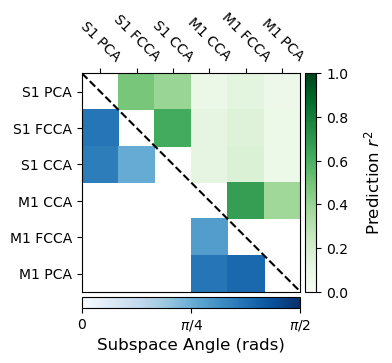

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
DIM = 6
# SSA on the lower triangle, r2 on the upper triangle

subspaces = ['S1_PCA', 'S1_FCCA', 'S1_CCA', 'M1_CCA', 'M1_FCCA', 'M1_PCA']
r2_array = np.zeros((len(subspaces), len(subspaces)))
# Manually arrange this
rdf_ = apply_df_filters(rdf, dim=DIM)
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            r2_array[i, j] = np.nan
        else:
            r2_array[i, j] = np.mean([rdf_.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_.shape[0])])

# Mask the lower half of the array
r2_array[:, 0] = np.nan
r2_array[1:, 1] = np.nan
r2_array[2:, 2] = np.nan
r2_array[3:, 3] = np.nan
r2_array[4:, 5] = np.nan
r2_array[4:, 5] = np.nan


r2_array_ma = masked_array(r2_array, mask=np.isnan(r2_array))

ss_array = np.zeros((len(subspaces), len(subspaces)))
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            ss_array[i, j] = np.nan
        else:
            if frozenset((s1, s2)) in rdf_.iloc[0]['ssa_dict'].keys():
                ss_array[i, j] = np.mean([rdf_.iloc[k]['ssa_dict'][frozenset((s1, s2))] for k in range(rdf_.shape[0])])
                print('valid')
            else:
                ss_array[i, j] = np.nan

# Mask the upper half of the array
ss_array[0, :] = np.nan
ss_array[1, 1:] = np.nan
ss_array[2, 2:] = np.nan
ss_array[3, 3:] = np.nan
ss_array[4, 4:] = np.nan
ss_array[5, 5:] = np.nan


ss_array_ma = masked_array(ss_array, mask=np.isnan(ss_array))

im1 = ax.pcolormesh(r2_array_ma, vmin=0, vmax=1, cmap='Greens')
im2 = ax.pcolormesh(ss_array_ma, vmin=0, vmax=np.pi/2, cmap='Blues')
ax.invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, orientation='vertical')

cax = divider.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, cax=cax, orientation='horizontal')
cbar2.set_ticks([0, np.pi/4, np.pi/2])
cbar2.set_ticklabels([0, r'$\pi/4$', r'$\pi/2$'])

ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax.set_xticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'], rotation=315)
ax.xaxis.tick_top()
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax.set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])

cbar.set_label('Prediction ' + r'$r^2$', fontsize=12, labelpad=10)
cbar2.set_label('Subspace Angle (rads)', fontsize=12)

ax.plot(np.arange(7), np.arange(7), color='k', linestyle='dashed')

#ax[0].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
#ax[0].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
#ax[0].set_title('Pairwise prediction ' + r'$r^2$')

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('below', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical')
ax.set_aspect('equal')
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/pairwise_r2ssd6_expanded.pdf', bbox_inches='tight', pad_inches=0)

In [7]:
from copy import deepcopy

valid
valid
valid
valid
valid
valid
valid
valid
valid
valid
valid
valid


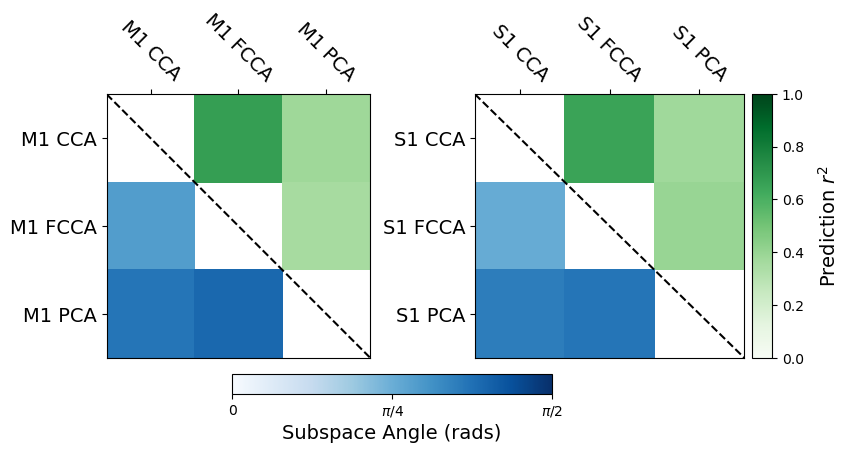

In [8]:
# Separate into 3 subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
DIM = 6

# SSA on the lower triangle, r2 on the upper triangle
# M1
subspaces = ['M1_CCA', 'M1_FCCA', 'M1_PCA']
r2_array = np.zeros((len(subspaces), len(subspaces)))
# Manually arrange this
rdf_ = apply_df_filters(rdf, dim=DIM)
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            r2_array[i, j] = np.nan
        else:
            r2_array[i, j] = np.mean([rdf_.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_.shape[0])])


# Mask the lower half of the array
# r2_array[:, 0] = np.nan
# r2_array[1:, 1] = np.nan
# r2_array[2:, 2] = np.nan
r2_arraym1 = deepcopy(r2_array)

r2_array_ma = masked_array(r2_array, mask=np.isnan(r2_array))

ss_array = np.zeros((len(subspaces), len(subspaces)))
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            ss_array[i, j] = np.nan
        else:
            if frozenset((s1, s2)) in rdf_.iloc[0]['ssa_dict'].keys():
                ss_array[i, j] = np.mean([rdf_.iloc[k]['ssa_dict'][frozenset((s1, s2))] for k in range(rdf_.shape[0])])
                print('valid')
            else:
                ss_array[i, j] = np.nan

# Mask the upper half of the array
ss_array[0, :] = np.nan
ss_array[1, 1:] = np.nan
ss_array[2, 2:] = np.nan


ss_array_ma = masked_array(ss_array, mask=np.isnan(ss_array))

im1 = ax[0].pcolormesh(r2_array_ma, vmin=0, vmax=1, cmap='Greens')
im2 = ax[0].pcolormesh(ss_array_ma, vmin=0, vmax=np.pi/2, cmap='Blues')
ax[0].invert_yaxis()
# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(im1, cax=cax, orientation='vertical')

# cax = divider.append_axes('bottom', size='5%', pad=0.05)
# cbar2 = fig.colorbar(im2, cax=cax, orientation='horizontal')
# cbar2.set_ticks([0, np.pi/4, np.pi/2])
# cbar2.set_ticklabels([0, r'$\pi/4$', r'$\pi/2$'])

ax[0].set_xticks([0.5, 1.5, 2.5])
ax[0].set_xticklabels(['M1 CCA', 'M1 FCCA', 'M1 PCA'], rotation=315, fontsize=14)
ax[0].xaxis.tick_top()
ax[0].set_yticks([0.5, 1.5, 2.5])
ax[0].set_yticklabels(['M1 CCA', 'M1 FCCA', 'M1 PCA'], fontsize=14)

ax[0].plot(np.arange(3.5), np.arange(3.5), color='k', linestyle='dashed')

ax[0].set_aspect('equal')


subspaces = ['S1_CCA', 'S1_FCCA', 'S1_PCA']
r2_array = np.zeros((len(subspaces), len(subspaces)))
# Manually arrange this
rdf_ = apply_df_filters(rdf, dim=DIM)
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            r2_array[i, j] = np.nan
        else:
            r2_array[i, j] = np.mean([rdf_.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_.shape[0])])


# Mask the lower half of the array
# r2_array[:, 0] = np.nan
# r2_array[1:, 1] = np.nan
# r2_array[2:, 2] = np.nan

r2_array_ma = masked_array(r2_array, mask=np.isnan(r2_array))

ss_array = np.zeros((len(subspaces), len(subspaces)))
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            ss_array[i, j] = np.nan
        else:
            if frozenset((s1, s2)) in rdf_.iloc[0]['ssa_dict'].keys():
                ss_array[i, j] = np.mean([rdf_.iloc[k]['ssa_dict'][frozenset((s1, s2))] for k in range(rdf_.shape[0])])
                print('valid')
            else:
                ss_array[i, j] = np.nan

# Mask the upper half of the array
ss_array[0, :] = np.nan
ss_array[1, 1:] = np.nan
ss_array[2, 2:] = np.nan


ss_array_ma = masked_array(ss_array, mask=np.isnan(ss_array))

im1 = ax[1].pcolormesh(r2_array_ma, vmin=0, vmax=1, cmap='Greens')
im2 = ax[1].pcolormesh(ss_array_ma, vmin=0, vmax=np.pi/2, cmap='Blues')
ax[1].invert_yaxis()

ax[1].set_xticks([0.5, 1.5, 2.5])
ax[1].set_xticklabels(['S1 CCA', 'S1 FCCA', 'S1 PCA'], rotation=315, fontsize=14)
ax[1].xaxis.tick_top()
ax[1].set_yticks([0.5, 1.5, 2.5])
ax[1].set_yticklabels(['S1 CCA', 'S1 FCCA', 'S1 PCA'], fontsize=14)


ax[1].plot(np.arange(3.5), np.arange(3.5), color='k', linestyle='dashed')

fig.tight_layout()

fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.1, 0.025, 0.66])
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='vertical')

fig.subplots_adjust(bottom=0.1)
cbar_ax2 = fig.add_axes([0.3, 0.01, 0.4, 0.05])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')

#divider = make_axes_locatable(ax[1])
#cax = divider.append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
# cax = divider.append_axes('bottom', size='5%', pad=0.05)
# cbar2 = fig.colorbar(im2, cax=cax, orientation='horizontal')
cbar2.set_ticks([0, np.pi/4, np.pi/2])
cbar2.set_ticklabels([0, r'$\pi/4$', r'$\pi/2$'])

cbar.set_label('Prediction ' + r'$r^2$', fontsize=14, labelpad=10)
cbar2.set_label('Subspace Angle (rads)', fontsize=14)

fig.savefig('/home/akumar/nse/neural_control/figs/cca/pairwise_r2ssd6_m1panel.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
ss_array_ma

masked_array(
  data=[[--, --, --],
        [0.9036379854085985, --, --],
        [1.1515269014635188, 1.2331889216461296, --]],
  mask=[[ True,  True,  True],
        [False,  True,  True],
        [False, False,  True]],
  fill_value=1e+20)

In [15]:
r2_arraym1

array([[       nan, 0.6755883 , 0.38158981],
       [0.59789795,        nan, 0.35849167],
       [0.40851571, 0.49535897,        nan]])

In [12]:
r2_array

array([[       nan, 0.40104738, 0.62413221],
       [0.48850673,        nan, 0.39563772],
       [0.65606677, 0.375426  ,        nan]])

In [9]:
r2_array_ma

masked_array(
  data=[[--, 0.4010473845864791, 0.6241322061899379],
        [--, --, 0.3956377226029627],
        [--, --, --]],
  mask=[[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]],
  fill_value=1e+20)

valid
valid
valid
valid
valid
valid


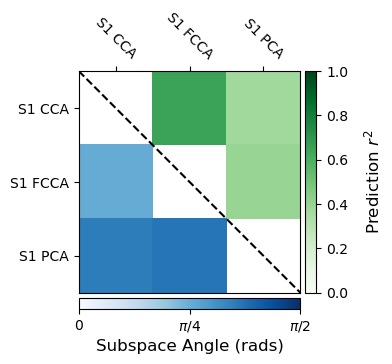

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
DIM = 6

# SSA on the lower triangle, r2 on the upper triangle
# S1
subspaces = ['S1_CCA', 'S1_FCCA', 'S1_PCA']
r2_array = np.zeros((len(subspaces), len(subspaces)))
# Manually arrange this
rdf_ = apply_df_filters(rdf, dim=DIM)
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            r2_array[i, j] = np.nan
        else:
            r2_array[i, j] = np.mean([rdf_.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_.shape[0])])


# Mask the lower half of the array
r2_array[:, 0] = np.nan
r2_array[1:, 1] = np.nan
r2_array[2:, 2] = np.nan

r2_array_ma = masked_array(r2_array, mask=np.isnan(r2_array))

ss_array = np.zeros((len(subspaces), len(subspaces)))
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            ss_array[i, j] = np.nan
        else:
            if frozenset((s1, s2)) in rdf_.iloc[0]['ssa_dict'].keys():
                ss_array[i, j] = np.mean([rdf_.iloc[k]['ssa_dict'][frozenset((s1, s2))] for k in range(rdf_.shape[0])])
                print('valid')
            else:
                ss_array[i, j] = np.nan

# Mask the upper half of the array
ss_array[0, :] = np.nan
ss_array[1, 1:] = np.nan
ss_array[2, 2:] = np.nan


ss_array_ma = masked_array(ss_array, mask=np.isnan(ss_array))

im1 = ax.pcolormesh(r2_array_ma, vmin=0, vmax=1, cmap='Greens')
im2 = ax.pcolormesh(ss_array_ma, vmin=0, vmax=np.pi/2, cmap='Blues')
ax.invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, orientation='vertical')

cax = divider.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, cax=cax, orientation='horizontal')
cbar2.set_ticks([0, np.pi/4, np.pi/2])
cbar2.set_ticklabels([0, r'$\pi/4$', r'$\pi/2$'])

ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['S1 CCA', 'S1 FCCA', 'S1 PCA'], rotation=315)
ax.xaxis.tick_top()
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_yticklabels(['S1 CCA', 'S1 FCCA', 'S1 PCA'])

cbar.set_label('Prediction ' + r'$r^2$', fontsize=12, labelpad=10)
cbar2.set_label('Subspace Angle (rads)', fontsize=12)

ax.plot(np.arange(3.5), np.arange(3.5), color='k', linestyle='dashed')

#ax[0].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
#ax[0].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
#ax[0].set_title('Pairwise prediction ' + r'$r^2$')

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('below', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical')
ax.set_aspect('equal')
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/pairwise_r2ssd6_s1panel.pdf', bbox_inches='tight', pad_inches=0)

In [14]:
ss_array_ma

masked_array(
  data=[[--, --, --],
        [0.8052598776603098, --, --],
        [1.1063585164577883, 1.153210490272523, --]],
  mask=[[ True,  True,  True],
        [False,  True,  True],
        [False, False,  True]],
  fill_value=1e+20)

In [15]:
r2_array_ma

masked_array(
  data=[[--, 0.6560667661111177, 0.3754260011074102],
        [--, --, 0.4010473845864791],
        [--, --, --]],
  mask=[[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]],
  fill_value=1e+20)

In [8]:
rdf_.shape

(40, 8)

In [17]:
rdf_.iloc[0]['fl']

'/mnt/Secondary/data/sabes_tmp50/indy_20160426_01.pkl'

In [10]:
np.unique(rdf_['fl'].values)

array(['/mnt/Secondary/data/sabes_tmp50/indy_20160426_01.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170210_03.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170213_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170215_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170227_04.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170228_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170301_05.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170302_02.pkl'],
      dtype=object)

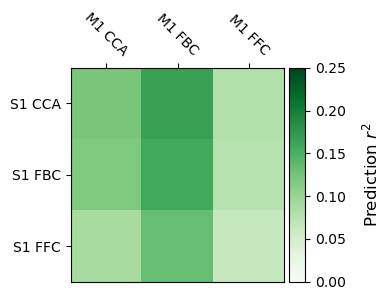

In [18]:
# cross-area r2 only
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
DIM = 6

# SSA on the lower triangle, r2 on the upper triangle
# S1
subspaces_x = ['S1_CCA', 'S1_FCCA', 'S1_PCA']
subspaces_y = ['M1_CCA', 'M1_FCCA', 'M1_PCA']
r2_array = np.zeros((3, 3))
# keep track off spread across recording sessions for calculation of statistics
r2_array_full = np.zeros((3, 3, 8))
# Manually arrange this
rdf_ = apply_df_filters(rdf, dim=DIM)
for i, s1 in enumerate(subspaces_x):
    for j, s2 in enumerate(subspaces_y):
        if s1 == s2:
            r2_array[i, j] = np.nan
        else:
            r2_array[i, j] = np.mean([rdf_.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_.shape[0])])
            for k, data_file in enumerate(np.unique(rdf_['fl'].values)):
                rdf_per_session = apply_df_filters(rdf_, fl=data_file)
                r2_array_full[i, j, k] = np.mean([rdf_per_session.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_per_session.shape[0])])

r2_array_ma = masked_array(r2_array, mask=np.isnan(r2_array))

im1 = ax.pcolormesh(r2_array_ma, vmin=0, vmax=0.25, cmap='Greens')
ax.invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='7.5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, orientation='vertical')

ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['M1 CCA', 'M1 FBC', 'M1 FFC'], rotation=315)
ax.xaxis.tick_top()
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_yticklabels(['S1 CCA', 'S1 FBC', 'S1 FFC'])

cbar.set_label('Prediction ' + r'$r^2$', fontsize=12, labelpad=10)

# ax.plot(np.arange(3.5), np.arange(3.5), color='k', linestyle='dashed')

#ax[0].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
#ax[0].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
#ax[0].set_title('Pairwise prediction ' + r'$r^2$')

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('below', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical')
ax.set_aspect('equal')
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/pairwise_r2ssd6_m1s1panel.pdf', bbox_inches='tight', pad_inches=0)

In [19]:
r2_array

array([[0.12135467, 0.16634408, 0.08073152],
       [0.1174663 , 0.15786205, 0.07681236],
       [0.08975152, 0.13191021, 0.06393461]])

In [25]:
print(scipy.stats.wilcoxon(r2_array_full[0, 1, :], r2_array_full[0, 2, :], alternative='greater'))
print(scipy.stats.wilcoxon(r2_array_full[1, 1, :], r2_array_full[1, 2, :], alternative='greater'))
print(scipy.stats.wilcoxon(r2_array_full[2, 1, :], r2_array_full[2, 2, :], alternative='greater'))

WilcoxonResult(statistic=36.0, pvalue=0.00390625)
WilcoxonResult(statistic=36.0, pvalue=0.00390625)
WilcoxonResult(statistic=36.0, pvalue=0.00390625)


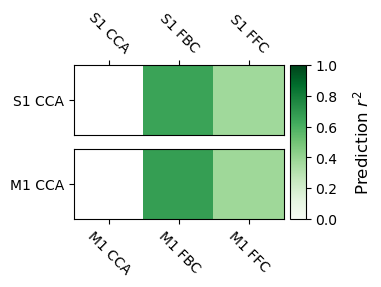

In [26]:
# Make an additional plot for the grant - just the first row of each inter-area plot...

fig, ax = plt.subplots(2, 1, figsize=(4, 2))
DIM = 6

# M1
subspaces = ['M1_CCA', 'M1_FCCA', 'M1_PCA']
r2_array = np.zeros((len(subspaces), len(subspaces)))
r2_array_full = np.zeros((len(subspaces), len(subspaces), 8))
# Manually arrange this
rdf_ = apply_df_filters(rdf, dim=DIM)
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            r2_array[i, j] = np.nan
        else:
            r2_array[i, j] = np.mean([rdf_.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_.shape[0])])
            for k, data_file in enumerate(np.unique(rdf_['fl'].values)):
                rdf_per_session = apply_df_filters(rdf_, fl=data_file)
                r2_array_full[i, j, k] = np.mean([rdf_per_session.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_per_session.shape[0])])

# Mask the lower half of the array
r2_array[:, 0] = np.nan
r2_array[1:, 1] = np.nan
r2_array[2:, 2] = np.nan

r2_array_ma = masked_array(r2_array, mask=np.isnan(r2_array))

im1 = ax[1].pcolormesh(r2_array_ma[0:1, :], vmin=0, vmax=1, cmap='Greens')
ax[1].invert_yaxis()

ax[1].set_xticks([0.5, 1.5, 2.5])
ax[1].set_xticklabels(['M1 CCA', 'M1 FBC', 'M1 FFC'], rotation=315)
#ax[1].xaxis.tick_top()

ax[1].set_yticks([0.5])
ax[1].set_yticklabels(['M1 CCA'])
#ax.set_yticks([0.5, 1.5, 2.5])
#ax.set_yticklabels(['S1 CCA', 'S1 FCCA', 'S1 PCA'])

#ax[0].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
#ax[0].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
#ax[0].set_title('Pairwise prediction ' + r'$r^2$')

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('below', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical')
ax[0].set_aspect('equal')



# S1
subspaces = ['S1_CCA', 'S1_FCCA', 'S1_PCA']
r2_array = np.zeros((len(subspaces), len(subspaces)))
# Manually arrange this
rdf_ = apply_df_filters(rdf, dim=DIM)
for i, s1 in enumerate(subspaces):
    for j, s2 in enumerate(subspaces):
        if s1 == s2:
            r2_array[i, j] = np.nan
        else:
            r2_array[i, j] = np.mean([rdf_.iloc[k]['r2_dict'][(s1, s2)] for k in range(rdf_.shape[0])])


# Mask the lower half of the array
r2_array[:, 0] = np.nan
r2_array[1:, 1] = np.nan
r2_array[2:, 2] = np.nan

r2_array_ma = masked_array(r2_array, mask=np.isnan(r2_array))

im1 = ax[0].pcolormesh(r2_array_ma[0:1, :], vmin=0, vmax=1, cmap='Greens')
ax[0].invert_yaxis()

ax[0].set_xticks([0.5, 1.5, 2.5])
ax[0].set_xticklabels(['S1 CCA', 'S1 FBC', 'S1 FFC'], rotation=315)
ax[0].xaxis.tick_top()

ax[0].set_yticks([0.5])
ax[0].set_yticklabels(['S1 CCA'])
#ax.set_yticks([0.5, 1.5, 2.5])
#ax.set_yticklabels(['S1 CCA', 'S1 FCCA', 'S1 PCA'])

#ax[0].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
#ax[0].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
#ax[0].set_title('Pairwise prediction ' + r'$r^2$')

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('below', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical')
ax[1].set_aspect('equal')
#fig.tight_layout()

#fig.subplots_adjust(right=0.99)
#cax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im1, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.2, pad=0.02, aspect=10)
cbar.set_label('Prediction ' + r'$r^2$', fontsize=12, labelpad=10)
fig.savefig('/home/akumar/nse/neural_control/figs/cca/within_area_for_grant.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# quick statistical tests
print(scipy.stats.wilcoxon(r2_array_full[0, 1, :], r2_array_full[0, 2, :], alternative='greater'))
print(scipy.stats.wilcoxon(r2_array_full[1, 1, :], r2_array_full[1, 2, :], alternative='greater'))
print(scipy.stats.wilcoxon(r2_array_full[2, 1, :], r2_array_full[2, 2, :], alternative='greater'))

### How much pairwise overlap is there between the 3 subspaces in each region? This informs the selection of neurons in the PSTH comparions

In [5]:
# Region: S1
# CCA fit on all data files, 50 ms
with open('/mnt/Secondary/data/postprocessed/sabes_cca50cv_df.dat', 'rb') as f:
    ccadf = pickle.load(f)
df_cca = pd.DataFrame(ccadf)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)

loco_df = pd.DataFrame(loco_df)
loco_dfS1 = apply_df_filters(pd.DataFrame(loco_df), loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'S1'},
                                    decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
loco_dfM1 = apply_df_filters(pd.DataFrame(loco_df), loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                                    decoder_args={'trainlag':4, 'testlag': 4, 'decoding_window': 5})

with open('/mnt/Secondary/data/postprocessed/indy_S1_df.dat', 'rb') as f:
    indy_dfS1 = pickle.load(f)
indy_dfS1 = pd.DataFrame(indy_dfS1)

with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_dfM1 = pickle.load(f)

indy_dfM1 = pd.DataFrame(indy_dfM1)

df_S1ss = pd.concat([loco_dfS1, indy_dfS1])
df_M1ss = pd.concat([loco_dfM1, indy_dfM1])


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CCA from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might 

In [19]:
data_files = [d.split('/')[-1].split('pkl')[0] + 'mat' for d in np.unique(df_cca['fl'].values)]
df_fca = apply_df_filters(df_S1ss, dimreduc_method='LQGCA', data_file=data_files)
df_fca = apply_df_filters(df_fca, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
df_pca = apply_df_filters(df_S1ss, dimreduc_method='PCA', data_file=data_files)

In [20]:
loadings_df = []
dim = 6
for i, data_file in enumerate(data_files):
    lcca_ = []
    lpca_ = []
    lfca_ = []
    for f in range(5):
        d1 = apply_df_filters(df_cca, fl='/mnt/Secondary/data/sabes_tmp50/%s.pkl' % data_file.split('.mat')[0], fold_idx=f)
        d2 = apply_df_filters(df_pca, data_file=data_file, fold_idx=f, dim=dim)
        d3 = apply_df_filters(df_fca, data_file=data_file, fold_idx=f, dim=dim)

        assert(d1.shape[0] == 1)
        assert(d2.shape[0] == 1)
        assert(d3.shape[0] == 1)

        lcca_.append(calc_loadings(d1.iloc[0]['ccamodel'].x_rotations_[:, 0:dim]))
        lpca_.append(calc_loadings(d2.iloc[0]['coef']))
        lfca_.append(calc_loadings(d3.iloc[0]['coef']))

    loadings_df.append({'data_file': data_file, 'lcca': np.mean(np.array(lcca_), axis=0), 'lpca': np.mean(np.array(lpca_), axis=0), 'lfca': np.mean(np.array(lfca_), axis=0)})

In [23]:
loadings_dfS1 = pd.DataFrame(loadings_df)

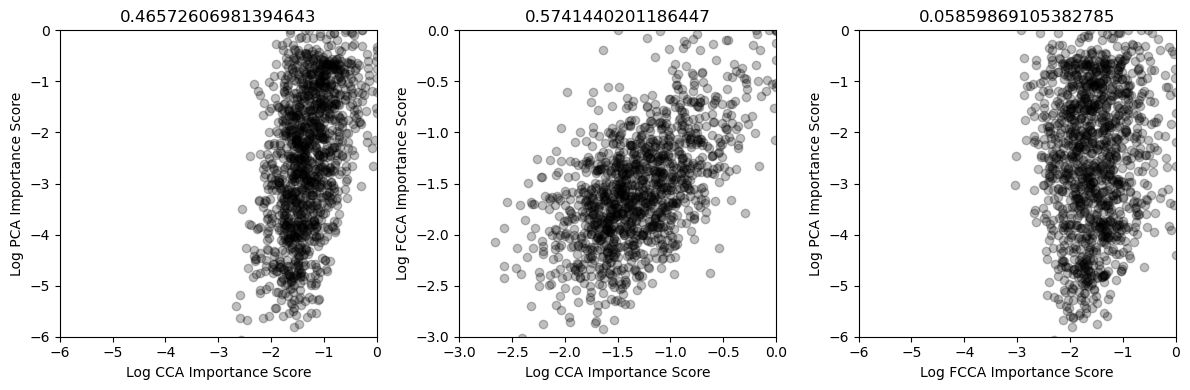

In [22]:
# Plot the pairwise loadings
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, data_file in enumerate(data_files):
    ax[0].scatter(np.log10(loadings_df.iloc[i]['lcca']), np.log10(loadings_df.iloc[i]['lpca']), color='k', alpha=0.25)
    ax[1].scatter(np.log10(loadings_df.iloc[i]['lcca']), np.log10(loadings_df.iloc[i]['lfca']), color='k', alpha=0.25)
    ax[2].scatter(np.log10(loadings_df.iloc[i]['lfca']), np.log10(loadings_df.iloc[i]['lpca']), color='k', alpha=0.25)

ax[0].set_ylim([-6, 0])
ax[0].set_xlim([-6, 0])
ax[0].set_xlabel('Log CCA Importance Score')
ax[0].set_ylabel('Log PCA Importance Score')
ax[0].set_title(scipy.stats.pearsonr(np.log10(loadings_df.iloc[i]['lcca']), np.log10(loadings_df.iloc[i]['lpca']))[0])


ax[1].set_xlim([-3, 0])
ax[1].set_ylim([-3, 0])
ax[1].set_xlabel('Log CCA Importance Score')
ax[1].set_ylabel('Log FCCA Importance Score')
ax[1].set_title(scipy.stats.pearsonr(np.log10(loadings_df.iloc[i]['lcca']), np.log10(loadings_df.iloc[i]['lfca']))[0])


ax[2].set_xlim([-6, 0])
ax[2].set_ylim([-6, 0])
ax[2].set_xlabel('Log FCCA Importance Score')
ax[2].set_ylabel('Log PCA Importance Score')
ax[2].set_title(scipy.stats.pearsonr(np.log10(loadings_df.iloc[i]['lfca']), np.log10(loadings_df.iloc[i]['lpca']))[0])
fig.tight_layout()


fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/cca_pairwise_loadingsS1.pdf', bbox_inches='tight', pad_inches=0)

In [24]:
# Region: M1
data_files = [d.split('/')[-1].split('pkl')[0] + 'mat' for d in np.unique(df_cca['fl'].values)]
df_fca = apply_df_filters(df_M1ss, dimreduc_method='LQGCA', data_file=data_files)
df_fca = apply_df_filters(df_fca, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
df_pca = apply_df_filters(df_M1ss, dimreduc_method='PCA', data_file=data_files)

In [25]:
loadings_df = []
dim = 6
for i, data_file in enumerate(data_files):
    lcca_ = []
    lpca_ = []
    lfca_ = []
    for f in range(5):
        d1 = apply_df_filters(df_cca, fl='/mnt/Secondary/data/sabes_tmp50/%s.pkl' % data_file.split('.mat')[0], fold_idx=f)
        d2 = apply_df_filters(df_pca, data_file=data_file, fold_idx=f, dim=dim)
        d3 = apply_df_filters(df_fca, data_file=data_file, fold_idx=f, dim=dim)

        assert(d1.shape[0] == 1)
        assert(d2.shape[0] == 1)
        assert(d3.shape[0] == 1)

        lcca_.append(calc_loadings(d1.iloc[0]['ccamodel'].y_rotations_[:, 0:dim]))
        lpca_.append(calc_loadings(d2.iloc[0]['coef']))
        lfca_.append(calc_loadings(d3.iloc[0]['coef']))

    loadings_df.append({'data_file': data_file, 'lcca': np.mean(np.array(lcca_), axis=0), 'lpca': np.mean(np.array(lpca_), axis=0), 'lfca': np.mean(np.array(lfca_), axis=0)})

In [26]:
loadings_dfM1 = pd.DataFrame(loadings_df)

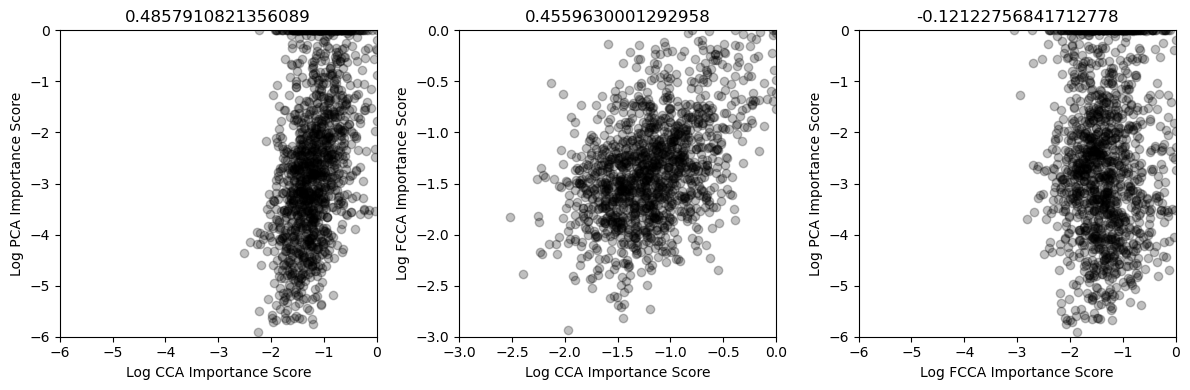

In [19]:
# Plot the pairwise loadings
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, data_file in enumerate(data_files):
    ax[0].scatter(np.log10(loadings_df.iloc[i]['lcca']), np.log10(loadings_df.iloc[i]['lpca']), color='k', alpha=0.25)
    ax[1].scatter(np.log10(loadings_df.iloc[i]['lcca']), np.log10(loadings_df.iloc[i]['lfca']), color='k', alpha=0.25)
    ax[2].scatter(np.log10(loadings_df.iloc[i]['lfca']), np.log10(loadings_df.iloc[i]['lpca']), color='k', alpha=0.25)

ax[0].set_ylim([-6, 0])
ax[0].set_xlim([-6, 0])
ax[0].set_xlabel('Log CCA Importance Score')
ax[0].set_ylabel('Log PCA Importance Score')
ax[0].set_title(scipy.stats.pearsonr(np.log10(loadings_df.iloc[i]['lcca']), np.log10(loadings_df.iloc[i]['lpca']))[0])


ax[1].set_xlim([-3, 0])
ax[1].set_ylim([-3, 0])
ax[1].set_xlabel('Log CCA Importance Score')
ax[1].set_ylabel('Log FCCA Importance Score')
ax[1].set_title(scipy.stats.pearsonr(np.log10(loadings_df.iloc[i]['lcca']), np.log10(loadings_df.iloc[i]['lfca']))[0])


ax[2].set_xlim([-6, 0])
ax[2].set_ylim([-6, 0])
ax[2].set_xlabel('Log FCCA Importance Score')
ax[2].set_ylabel('Log PCA Importance Score')
ax[2].set_title(scipy.stats.pearsonr(np.log10(loadings_df.iloc[i]['lfca']), np.log10(loadings_df.iloc[i]['lpca']))[0])
fig.tight_layout()


fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/cca_pairwise_loadingsM1.pdf', bbox_inches='tight', pad_inches=0)

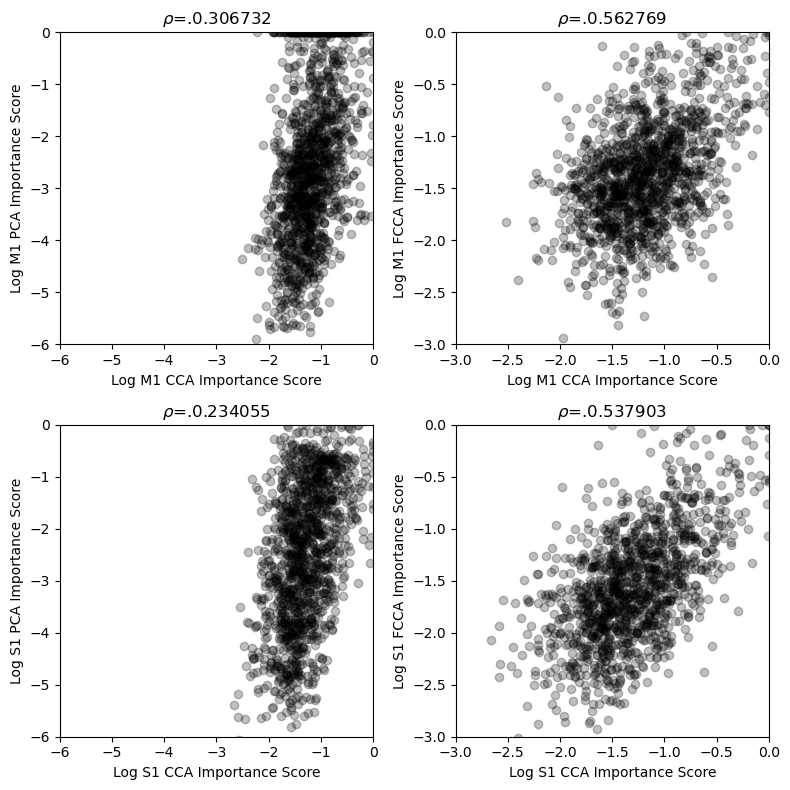

In [29]:
# Plot CC only in 1 plot
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, data_file in enumerate(data_files):
    ax[0, 0].scatter(np.log10(loadings_dfM1.iloc[i]['lcca']), np.log10(loadings_dfM1.iloc[i]['lpca']), color='k', alpha=0.25)
    ax[0, 1].scatter(np.log10(loadings_dfM1.iloc[i]['lcca']), np.log10(loadings_dfM1.iloc[i]['lfca']), color='k', alpha=0.25)
    ax[1, 0].scatter(np.log10(loadings_dfS1.iloc[i]['lcca']), np.log10(loadings_dfS1.iloc[i]['lpca']), color='k', alpha=0.25)
    ax[1, 1].scatter(np.log10(loadings_dfS1.iloc[i]['lcca']), np.log10(loadings_dfS1.iloc[i]['lfca']), color='k', alpha=0.25)


regions = ['M1', 'S1']
for i in range(2):
    ax[i, 0].set_ylim([-6, 0])
    ax[i, 0].set_xlim([-6, 0])
    ax[i, 0].set_xlabel('Log %s CCA Importance Score' % regions[i])
    ax[i, 0].set_ylabel('Log %s PCA Importance Score' % regions[i])

    ax[i, 1].set_xlim([-3, 0])
    ax[i, 1].set_ylim([-3, 0])
    ax[i, 1].set_xlabel('Log %s CCA Importance Score' % regions[i])
    ax[i, 1].set_ylabel('Log %s FCCA Importance Score' % regions[i])

ax[0, 0].set_title(r'$\rho$' + '=.%3f' % scipy.stats.pearsonr(np.log10(loadings_dfM1.iloc[i]['lcca']), np.log10(loadings_dfM1.iloc[i]['lpca']))[0])
ax[0, 1].set_title(r'$\rho$' + '=.%3f' % scipy.stats.pearsonr(np.log10(loadings_dfM1.iloc[i]['lcca']), np.log10(loadings_dfM1.iloc[i]['lfca']))[0])
ax[1, 0].set_title(r'$\rho$' + '=.%3f' % scipy.stats.pearsonr(np.log10(loadings_dfS1.iloc[i]['lcca']), np.log10(loadings_dfS1.iloc[i]['lpca']))[0])
ax[1, 1].set_title(r'$\rho$' + '=.%3f' % scipy.stats.pearsonr(np.log10(loadings_dfS1.iloc[i]['lcca']), np.log10(loadings_dfS1.iloc[i]['lfca']))[0])


fig.tight_layout()



In [ ]:
# Note the type int he first two figures. So we don't have to include this.